In [1]:
#!pip install -U scikit-learn
#!pip install -U imbalanced-learn
#!pip install plot_metric
#!pip install category_encoders

In [ ]:
#Please run pip install if you don't have the packages

In [74]:
#preprocessing, pipelining
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer , make_column_selector
from sklearn.metrics import balanced_accuracy_score, recall_score,precision_score,make_scorer,matthews_corrcoef

#feature selection tools
from sklearn.feature_selection import VarianceThreshold

#Data Imbalance tools
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

#utility
import pandas as pd
import numpy as np
import pickle

#models
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import RUSBoostClassifier
from xgboost import XGBClassifier

#model selection
from sklearn.model_selection import  GridSearchCV

#plotting
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from xgboost import to_graphviz
from xgboost import plot_importance

### Setting up training and validation 

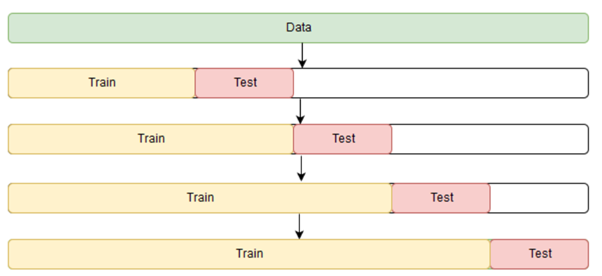

In [3]:
#Custom training/validation split
def rolling_forecast_origin(X_train): #creating a generator function to produce a rolling forecast window, increasing training data by 1 months and validating on 1 months after.
  for month in range(1,13):
    if month > 1:
      X_split_train = X_train.loc['2012-1':f'2014-{month-1}']
      X_split_val = X_train.loc[f'2014-{month}']
    
    else:
      X_split_train = X_train.loc['2012-1':'2013-12']
      X_split_val = X_train.loc['2014-01']

    yield X_split_train,X_split_val

In [4]:
def rolling_test(model,cv):

  scoring_df = pd.DataFrame(columns = ['model','train_acc','test_acc','train_prec','test_prec','train_rec','test_rec','train_mcc','test_mcc'])
  
  for X_split_train,X_split_val in cv:
    model.fit(X_split_train)
    train_preds = model.predict(X_split_train)
    test_preds = model.predict(X_split_val)

    train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
    train_prec = precision_score(y_tr,train_preds)
    train_rec = recall_score(y_tr,train_preds)
    train_mcc = matthews_corrcoef(y_tr,train_preds)

    test_acc = balanced_accuracy_score(y_t,test_preds) #test metrics
    test_prec = precision_score(y_t,test_preds)
    test_rec = recall_score(y_t,test_preds)
    test_mcc = matthews_corrcoef(y_t,test_preds)

    new_row ={'model':model_name,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_mcc':train_mcc,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec,'test_mcc':test_mcc  #test metric
            }
    scoring_df = scording_df.append(new_row,ignore_index = True)
    return scoring_df


In [5]:
def rolling_forecast_test(X_train,X_test): #creating a generator function to produce a rolling forecast window, increasing training data by 1 months and test on 1 months after.
  for month in range(1,13):
    if month > 1:
      X_split_train = X_test.loc['2015-1':f'2015-{month-1}']
      X_spit_train = pd.concat([X_train,X_split_train], axis = 1)

      X_split_val = X_test.loc[f'2015-{month}']
    
    else:
      X_split_train = X_train.loc['2012-1':'2014-12']
      X_split_val = X_test.loc['2015-01']

    yield X_split_train,X_split_val

In [6]:
def cv_generator(cv):

  cv_list = []

  for x_train,x_val in cv:
    z_train = x_train.reset_index() # gridsearchCV does not accept dates as index, resetting to remove dates as index
   
    adjustments = z_train.index[-1] 

    z_val = x_val.reset_index()
    z_val.index += adjustments + 2 #s reset_index() will make index start from 0, the value of the last of row + 2 is added to the index value as adjustments.

    cv_list.append((z_train.index,z_val.index[:-1]))
  
  return cv_list

In [25]:
scoring_df = pd.DataFrame(columns = ['model','train_acc','test_acc','train_prec','test_prec','train_rec','test_rec','train_mcc','test_mcc'])


def print_results(model,X_tr,X_t,y_tr,y_t,model_name):
    train_preds = model.predict(X_tr)
    test_preds = model.predict(X_t)

    train_acc = balanced_accuracy_score(y_tr,train_preds) #train metrics
    train_prec = precision_score(y_tr,train_preds)
    train_rec = recall_score(y_tr,train_preds)
    train_mcc = matthews_corrcoef(y_tr,train_preds)

    test_acc = balanced_accuracy_score(y_t,test_preds) #test metrics
    test_prec = precision_score(y_t,test_preds)
    test_rec = recall_score(y_t,test_preds)
    test_mcc = matthews_corrcoef(y_t,test_preds)

    new_row ={'model':model_name,
              'train_acc':train_acc,'train_prec':train_prec,'train_rec':train_rec,'train_mcc':train_mcc,  #train metric
              'test_acc':test_acc,'test_prec':train_prec,'test_rec':train_rec, 'test_mcc':test_mcc #test metric
              }

    print(f'train - balanced acc : {train_acc} , precision : {train_prec} , recall: {train_rec}, mcc: {train_mcc}')
    print(f'test - balanced acc : {test_acc} , precision : {test_prec} , recall: {test_rec}, mcc: {test_mcc}')

    return new_row

In [26]:
def evaluation_plot(model,X_tr,X_t,y_tr,y_t,model_name):

  train_preds = model.predict(X_tr)
  test_preds = model.predict(X_t)

  train_proba= model.predict_proba(X_tr)
  test_proba = model.predict_proba(X_t)

  new_row = print_results(model,X_tr,X_t,y_tr,y_t,model_name)

  plt.figure(figsize=(24,12))
  bc = BinaryClassification(y_tr, train_proba[::,1], labels=["Not Fraud", "Fraud"])
  bc1 = BinaryClassification(y_t, test_proba[::,1], labels=["Not Fraud", "Fraud"])

  #plotting ROC-AUC curve
  plt.subplot2grid(shape=(3,12), loc=(0,0), colspan=3)
  bc.plot_roc_curve(title = 'Training - ROC')
  plt.subplot2grid(shape=(3,12), loc=(0,3), colspan=3)
  bc1.plot_roc_curve(title  = 'Testing - ROC')
  
  #plotting Precission-recall curve
  plt.subplot2grid((3,12), (1,0), colspan=3)
  bc.plot_precision_recall_curve(title = 'Training - Precision -Recall Curve')
  plt.subplot2grid((3,12), (1,3), colspan=3)
  bc1.plot_precision_recall_curve(title = 'Testing - Precision -Recall Curve')

  #plot confusion matrix
  plt.subplot2grid((3,12), (0,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training')
  plt.subplot2grid((3,12), (0,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing')

'''
  #plot confusion matrix with the values normalized
  plt.subplot2grid((3,12), (1,6), colspan=3)
  bc.plot_confusion_matrix(title ='Training' , normalize = True)
  plt.subplot2grid((3,12), (1,9), colspan=3)
  bc1.plot_confusion_matrix(title = 'Testing', normalize = True)

  plt.subplot2grid((3,12), (2,3), colspan=3)
  bc.plot_class_distribution(title ='Training')
  plt.subplot2grid((3,12), (2,6), colspan=3)
  bc1.plot_class_distribution(title = 'Testing')
'''
  return new_row

In [9]:
def plot_cross_val_results(gs):
  print(f'best params {gs.best_params_}')
  print(f'best validation balanced acurracy :{gs.best_score_}')

  fig,ax = plt.subplots(nrows = 2, ncols =2,figsize = (24,12))

  for i,metric in enumerate(['balanced_accuracy','precision','recall','mcc']):

    row = i//2 #when i = 0,1, i//2 == 0 when i = 2, i//2 == 1
    col = i%2  #if i is odd, col == 1, if i is even col = 0 
    
    #plot each scoring metric of each permutation of the parameters of each fold.
    pd.DataFrame(gs.cv_results_).drop(columns = [f'rank_test_{metric}',f'mean_test_{metric}',f'std_test_{metric}'],axis = 'columns')\
                                        .filter(like =f'test_{metric}').T\
                                        .plot(ax = ax[row,col], legend = False).set_title(f'{metric}')
    ax[row,col].set_xticks(range(12))
    ax[row,col].set_xticklabels(range(1,13))
    ax[row,col].set_xlabel('split')

    #ax[row,col].legend(loc='upper right')
    ax[row,col].set_ylim([0, 1])
  return gs.best_score_

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading in data

In [11]:
df_train = pd.read_csv('assets/train_engineered.csv')
df_test = pd.read_csv('assets/test_engineered.csv')

In [12]:
df_train.fillna(0,inplace = True )
df_test.fillna(0,inplace = True )

In [13]:
df_train['trans_date_time'] = pd.to_datetime(df_train['trans_date_time'])
df_train.sort_values(by = 'trans_date_time', inplace = True)
df_train.set_index('trans_date_time',inplace = True)
df_test['trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.sort_values(by = 'trans_date_time', inplace = True)
df_test.set_index('trans_date_time',inplace = True)

In [14]:
df_train['hour'] = df_train.index.hour
df_test['hour'] = df_test.index.hour

def time_risk(df_):
  x = df_['hour']
  condlist = [x<4,x>21, (x>=4)&(x<=21)]
  choicelist = [1,1,0]
  df_['time_risk'] = np.select(condlist,choicelist)

  return df_

df_train = time_risk(df_train)
df_test = time_risk(df_test)

In [15]:
features = ['cc_num','job','category','merchant','amt','trans_month','weekday','time_risk',
            'day','age_at_trans','flag_cat_amt','rolling_cat_5d','flag_1','flag_2']

In [16]:
X_train = df_train.loc[:,features].copy()
X_train['job'] = X_train['job'].astype('category')
X_train['merchant'] = X_train['job'].astype('category')
X_train['cc_num'] = X_train['cc_num'].astype('category')
y_train = df_train.loc[:,'is_fraud'].copy()


X_test = df_test.loc[:,features].copy()
X_test['job'] = X_test['job'].astype('category')
X_test['merchant'] = X_test['job'].astype('category')
X_test['cc_num'] = X_test['cc_num'].astype('category')
y_test= df_test.loc[:,'is_fraud'].copy()

### Setting up Pipeline

In [124]:
ohe = OneHotEncoder()
scaler = MinMaxScaler()
#sm = SMOTENC(random_state=42,sampling_strategy = 0.15, categorical_features=[0,1,2,3]) # not enough ram to run this.
tgt = TargetEncoder(smoothing = 50) #adding a smoothing factor as some of the jobs/cc num has very small samples, adding smoothing factor to reduce overfitting.
var = VarianceThreshold(threshold=(.95 * (1 - .95))) # remove all features that are 95% 0 or 1

ctf = make_column_transformer((scaler,make_column_selector(dtype_include=np.number)), # run mix-max scaler on numerical data type, saga solver requires a scaled dataset.
#                              (ohe,make_column_selector(dtype_include = object)), #One hot encode object daatype
                              (tgt,['job','merchant','cc_num','category']), #base on our EDA there seems to be some jobs, merchants and even credit-cards are more prone to fradulent activites than others.
                              remainder = 'passthrough')

ratio = 0.15
over = RandomOverSampler(sampling_strategy = ratio)
under = RandomUnderSampler(sampling_strategy = 0.65)


weight = 1/ratio


log_model = make_pipeline(ctf,
#                         var,
                          over,
#                         under,  
                          LogisticRegression(class_weight='balanced', max_iter = 1000, solver = 'saga', tol = 0.1)) #using class weights to adjust for class imbalance

xgboost_model = make_pipeline(ctf,
                              over, #over sample positive class
#                             under,
                              var,
                              XGBClassifier(tree_method = 'hist',
                                            max_delta_step = 10,
                                            subsample = 0.7,colsample_by_tree = 0.7, 
                                            min_child_weight = 30,gamma = 30,
                                            objective = 'binary:logistic',
#                                            scale_pos_weight = weight #and provide a weight to adjust for the class imbalance
                                            ))

rus_model = make_pipeline(ctf,
                          over,
                          RUSBoostClassifier())

In [18]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {'logisticregression__C':np.linspace(0.01,0.1,5)} #tested 0.01 to 1

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'mcc' : make_scorer(matthews_corrcoef)}


gs = GridSearchCV(log_model, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=cv, # custom folds 
                  scoring = scoring,
                  refit = 'balanced_accuracy',
                  n_jobs = 2) 

In [19]:
gs.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=[(RangeIndex(start=0, stop=923485, step=1),
                  RangeIndex(start=923486, stop=949732, step=1)),
                 (RangeIndex(start=0, stop=949732, step=1),
                  RangeIndex(start=949733, stop=973728, step=1)),
                 (RangeIndex(start=0, stop=973728, step=1),
                  RangeIndex(start=973729, stop=1009239, step=1)),
                 (RangeIndex(start=0, stop=1009239, step=1),
                  RangeIndex(start=1009240, stop=104236...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='saga',
                                                           tol=0.1))]),
             n_jobs=2,
             param_grid={'logisticregression__C': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])},
             refit='balanced_accuracy',
             scoring={'balanced_ac

In [20]:
with open('logistic_regression', 'wb') as files:
    pickle.dump(gs, files)

best params {'logisticregression__C': 0.0775}
best validation balanced acurracy :0.9080002981738503


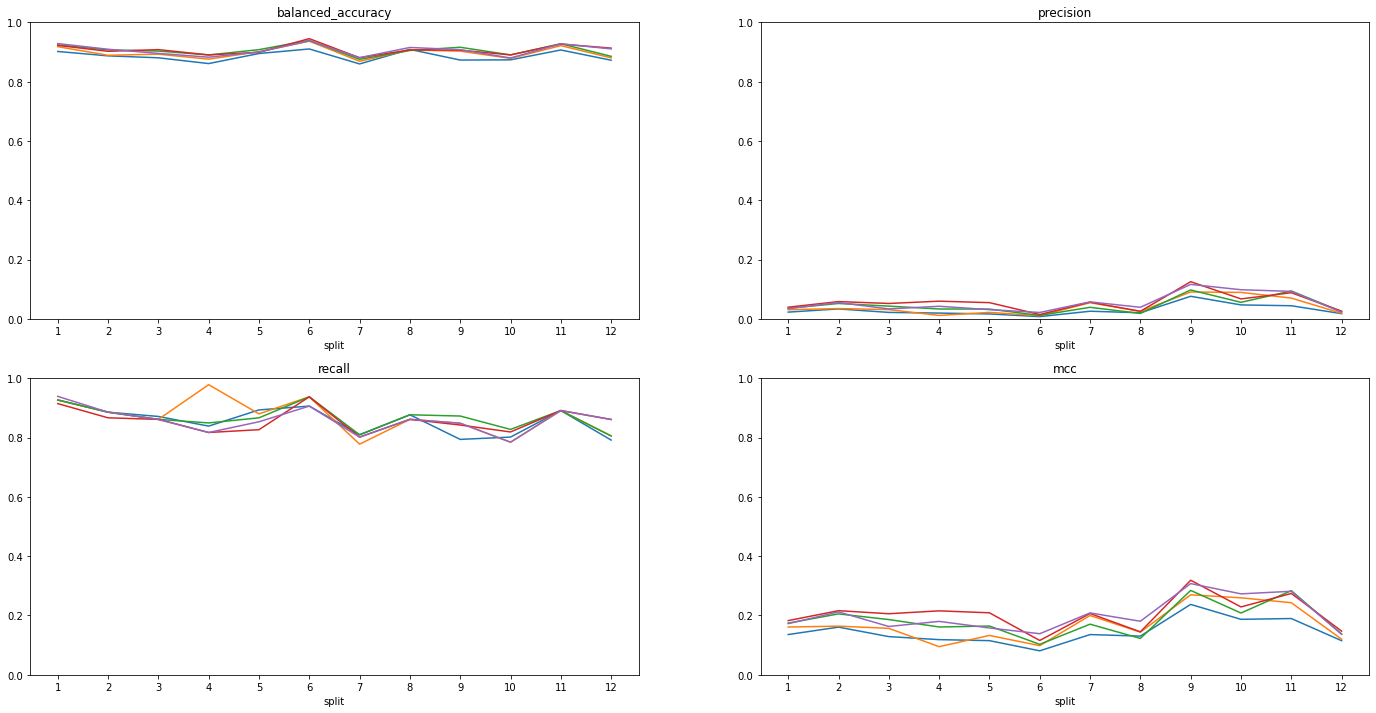

In [21]:
best_score = plot_cross_val_results(gs)

In [22]:
#names =gs.best_estimator_[0].get_feature_names()
#[f'{name}-x{i}a' for i,name in enumerate(names,1)]

In [23]:
'''
importance = gs.best_estimator_.named_steps["logisticregression"].coef_[0]
feature_importance = pd.DataFrame({'features' :gs.best_estimator_[0].get_feature_names,
                                   'coefficient' : abs(importance)}).sort_values(by='coefficient', ascending = False)
feature_importance['rank'] = feature_importance['coefficient'].rank(ascending = False)                                 
plt.figure(figsize = (12,7))  
sns.barplot( y= feature_importance['features'], x = feature_importance['coefficient'], orient = 'h', color = 'lightblue');
'''

'\nimportance = gs.best_estimator_.named_steps["logisticregression"].coef_[0]\nfeature_importance = pd.DataFrame({\'features\' :gs.best_estimator_[0].get_feature_names,\n                                   \'coefficient\' : abs(importance)}).sort_values(by=\'coefficient\', ascending = False)\nfeature_importance[\'rank\'] = feature_importance[\'coefficient\'].rank(ascending = False)                                 \nplt.figure(figsize = (12,7))  \nsns.barplot( y= feature_importance[\'features\'], x = feature_importance[\'coefficient\'], orient = \'h\', color = \'lightblue\');\n'

train - balanced acc : 0.922031195218486 , precision : 0.03664549467111637 , recall: 0.9089452603471295, mcc: 0.17523690183396684
test - balanced acc : 0.9060660977856626 , precision : 0.03529847230634632 , recall: 0.8770903010033445, mcc: 0.16845723070107804


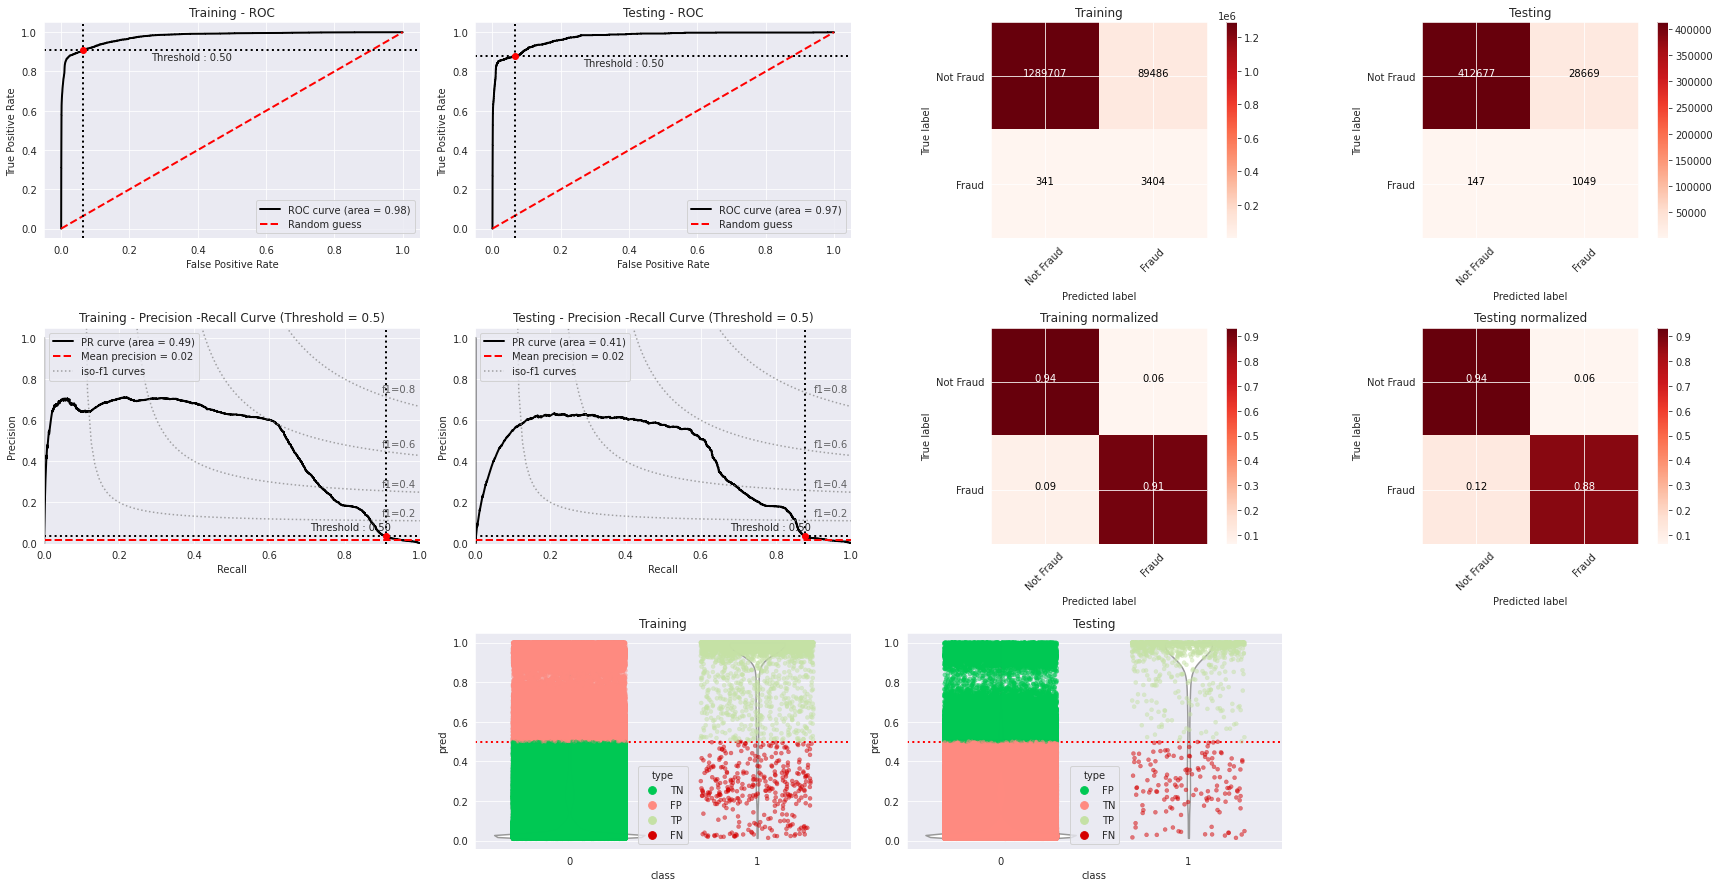

In [28]:
new_row = evaluation_plot(gs,X_train,X_test,y_train,y_test,'Logistic')

In [29]:
scoring_df = scoring_df.append(new_row,ignore_index = True) #storing scores

In [130]:
rolling_cv = rolling_forecast_origin(X_train)
cv = cv_generator(rolling_cv)

pipe_params = {'xgbclassifier__max_depth':[7],
               'xgbclassifier__gamma':[10],
               'xgbclassifier__min_child_weight':[10]}

scoring = {'balanced_accuracy' : make_scorer(balanced_accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'mcc' : make_scorer(matthews_corrcoef)
          }


gs = GridSearchCV(xgboost_model, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=cv, # custom folds z
                  scoring = scoring,
                  refit = 'balanced_accuracy') 

In [131]:
gs.fit(X_train,y_train)

GridSearchCV(cv=[(RangeIndex(start=0, stop=923485, step=1),
                  RangeIndex(start=923486, stop=949732, step=1)),
                 (RangeIndex(start=0, stop=949732, step=1),
                  RangeIndex(start=949733, stop=973728, step=1)),
                 (RangeIndex(start=0, stop=973728, step=1),
                  RangeIndex(start=973729, stop=1009239, step=1)),
                 (RangeIndex(start=0, stop=1009239, step=1),
                  RangeIndex(start=1009240, stop=104236...
                                                      subsample=0.7,
                                                      tree_method='hist'))]),
             param_grid={'xgbclassifier__gamma': [10],
                         'xgbclassifier__max_depth': [7],
                         'xgbclassifier__min_child_weight': [10]},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'mcc': make_scorer(matthews_cor

In [132]:
gs.best_params_

{'xgbclassifier__gamma': 10,
 'xgbclassifier__max_depth': 7,
 'xgbclassifier__min_child_weight': 10}

train - balanced acc : 0.8728277900465347 , precision : 0.19567627494456763 , recall: 0.7540720961281709, mcc: 0.3813204460443373
test - balanced acc : 0.835564315134667 , precision : 0.19083431257344302 , recall: 0.6789297658862876, mcc: 0.3570523341893792


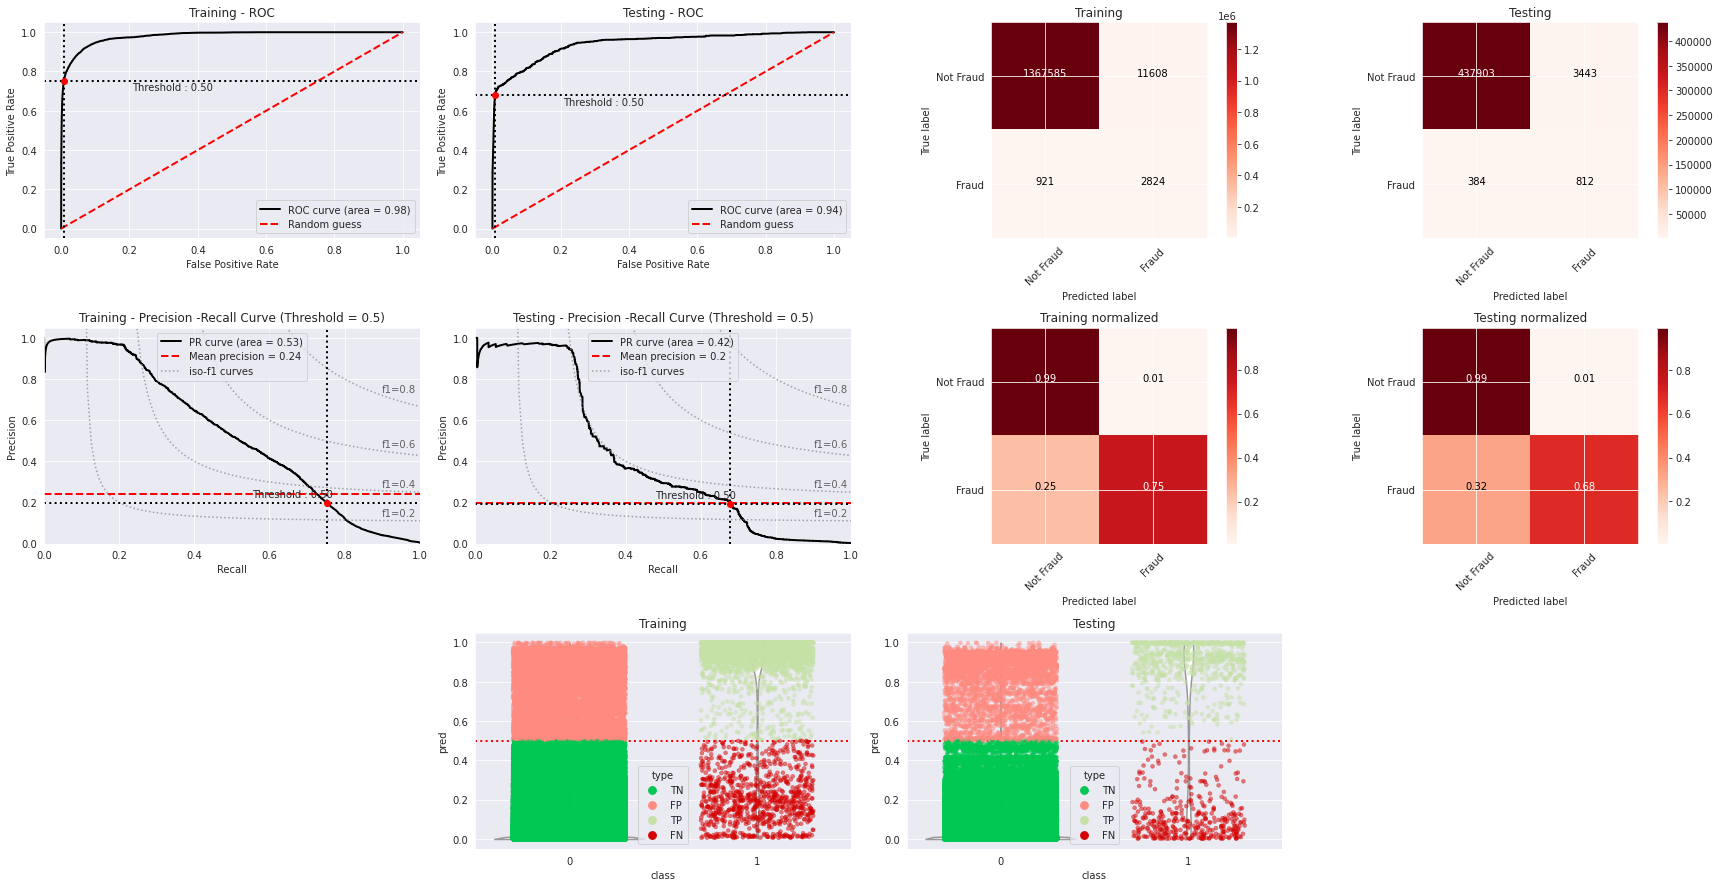

In [133]:
new_row = evaluation_plot(gs,X_train,X_test,y_train,y_test,'xgboost')
scoring_df = scoring_df.append(new_row,ignore_index = True)

best params {'xgbclassifier__gamma': 10, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 10}
best validation balanced acurracy :0.8326231041443838


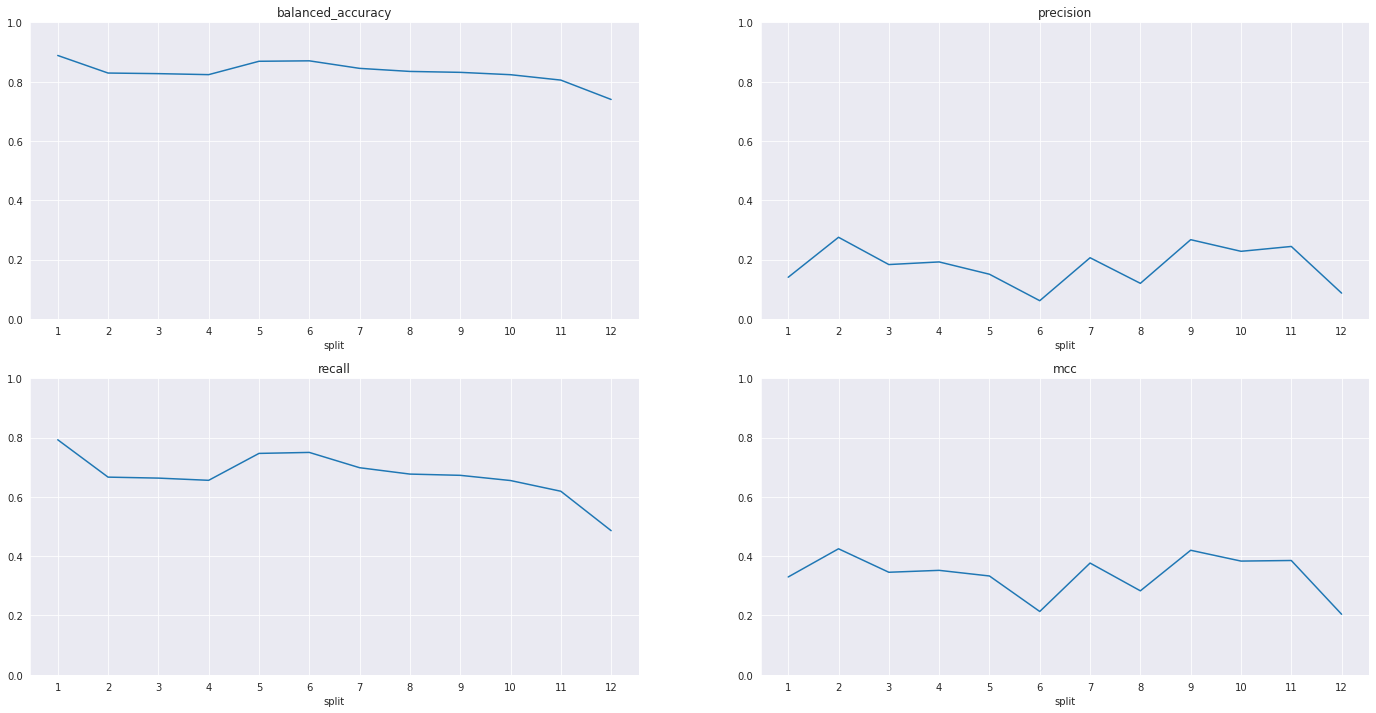

In [134]:
best_score = plot_cross_val_results(gs)

In [35]:
#gs.best_estimator_.named_steps["xgbclassifier"].get_booster().feature_names = list(X_train.columns)

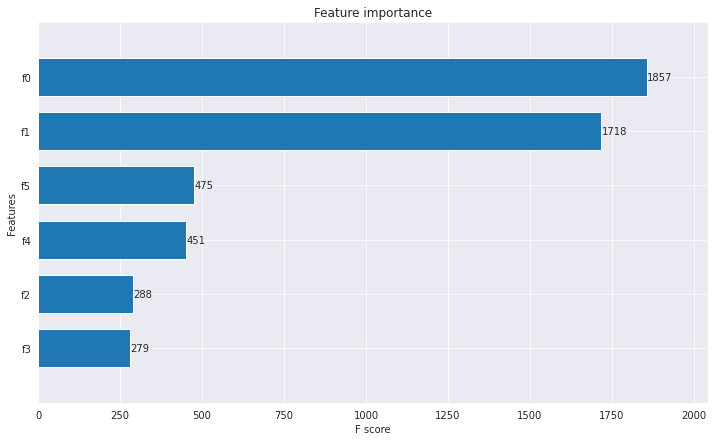

In [98]:
fig,ax = plt.subplots(figsize = (12,7))
plot_importance(gs.best_estimator_.named_steps["xgbclassifier"].get_booster(), height = 0.7,ax = ax)
plt.rc('font', size=10)

In [110]:
ctf.fit(X_train,y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3f37596a10>),
                                ('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3f37596a90>),
                                ('targetencoder', TargetEncoder(smoothing=50.0),
                                 ['job', 'merchant', 'cc_num'])])